In [2]:
from qiskit import * 

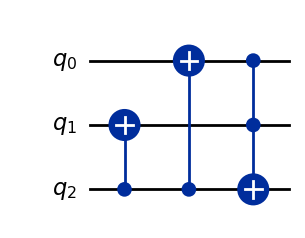

In [3]:
def qc_MAJ() -> QuantumCircuit:
    quantum_circuit = QuantumCircuit(3)
    quantum_circuit.name = "MAJ"
    quantum_circuit.cx(2, 1)
    quantum_circuit.cx(2, 0)
    quantum_circuit.ccx(0, 1, 2)
    return quantum_circuit

qc_MAJ().draw("mpl")

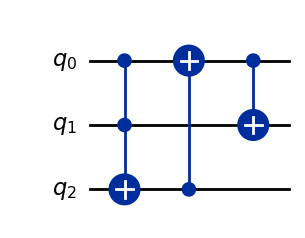

In [4]:
def qc_UMA(two_version: bool=True) -> QuantumCircuit:
    #if argument is true, implements the 2cnot version, else, implements the 3cnot version
    #check reference
    quantum_circuit = QuantumCircuit(3)
    quantum_circuit.name = "UMA"
    if two_version:
        quantum_circuit.ccx(0, 1, 2)
        quantum_circuit.cx(2, 0)
        quantum_circuit.cx(0, 1)
    else:
        quantum_circuit.x(1)
        quantum_circuit.cx(0, 1)
        quantum_circuit.ccx(0, 1, 2)
        quantum_circuit.x(1)
        quantum_circuit.cx(2, 0)
        quantum_circuit.cx(2, 1)
    return quantum_circuit

qc_UMA().draw("mpl")

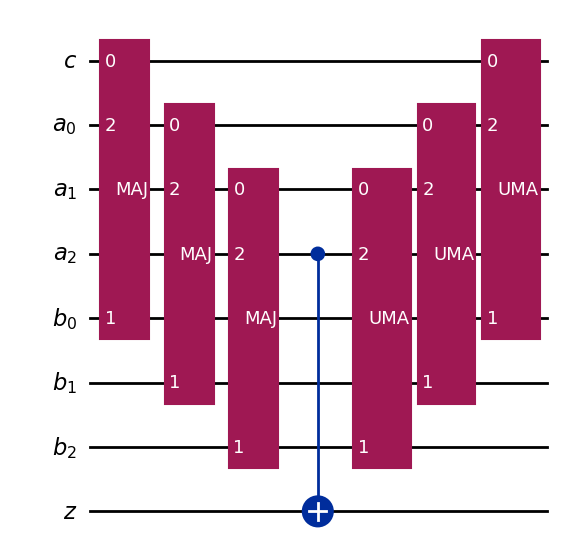

In [12]:
def adder_CDKM(num_qubits: int, modulo_2n: bool=False) -> QuantumCircuit:
    c = QuantumRegister(1, name="c")
    a = QuantumRegister(num_qubits, name="a")
    b = QuantumRegister(num_qubits, name="b")
    if not modulo_2n:
        z = QuantumRegister(1, name="z") 
        quantum_circuit = QuantumCircuit(c,a,b,z, name="Adder-CDKM")
    else:
        quantum_circuit = QuantumCircuit(c,a,b, name="Adder-CDKM-MOD2^n")
    
    quantum_circuit.append(qc_MAJ(), c[0:1] + b[0:1] + a[0:1])

    for i in range(1, num_qubits):
        quantum_circuit.append(qc_MAJ(), a[i-1:i] + b[i:i+1] + a[i:i+1])

    if not modulo_2n: quantum_circuit.cx(a[-1], z[0])
        
    for i in range(num_qubits-1, 0, -1):
        quantum_circuit.append(qc_UMA(), a[i-1:i] + b[i:i+1] + a[i:i+1])
        
    quantum_circuit.append(qc_UMA(), c[0:1] + b[0:1] + a[0:1])
    return quantum_circuit

adder_CDKM(3).draw("mpl")

In [11]:
from qiskit.quantum_info import Statevector

Statevector.from_label("1110100").evolve(adder_CDKM(3, True)).draw("latex")

<IPython.core.display.Latex object>